In [ ]:
import numpy as np
import seaborn as sns
import scanpy as sc
from sklearn import mixture
import pickle
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib
from random import sample
import pickletools
import hmmlearn
from hmmlearn.hmm import CategoricalHMM
import csv
from natsort import natsorted
import anndata as ad

In [ ]:
# Load and example dataset in a dictionary containing all the ratio values for each embryo and chromosome
wt = pd.read_pickle("../metadata/wt75_dict.pkl")

In [5]:
chromosomes = list()
for i in range(1, 19+1):
    chromosomes.append(f"chr{i}")

In [6]:
def ratio2int(df):
    df.dropna(inplace=True)
    df.loc[df['Ratio'] < 0.5, 'obs_state_pro'] = 0
    df.loc[((df['Ratio'] >= 0.5) & (df['Ratio'] < 0.6)), 'obs_state_pro'] = 1
    df.loc[((df['Ratio'] >= 0.6) & (df['Ratio'] < 0.7)), 'obs_state_pro'] = 2
    df.loc[((df['Ratio'] >= 0.7) & (df['Ratio'] < 0.8)), 'obs_state_pro'] = 3
    df.loc[((df['Ratio'] >= 0.8) & (df['Ratio'] < 0.9)), 'obs_state_pro'] = 4
    df.loc[((df['Ratio'] >= 0.9) & (df['Ratio'] <= 1)), 'obs_state_pro'] = 5

    return df

# Train the model on a random set of sequences (all together)

In [ ]:
np.random.seed(40)  # Set a random seed

fit_embryos = sample(list(wt.keys()), 10)
fit_chromosomes = sample(chromosomes, 8)

X = list()
lengths = list()
for embryo in fit_embryos:
    print(f"Processing {embryo}")
    for chr in fit_chromosomes:
        wt_df = pd.DataFrame(wt[embryo][chr].mean(axis=0), columns=['Ratio']).reset_index().rename(columns={"index":"Gene"})

        #convert ratio numbers into integers
        wt_df = ratio2int(wt_df)
        
        X_train = wt_df.obs_state_pro.to_numpy()
        lengths.append(X_train.shape[0])

        X_train = X_train.reshape(-1, 1)
        X_train = X_train.astype(int)

        X.append(X_train)

X = np.concatenate(X)

# we want the hidden state BC to be 0 so it has to be the first state in the model.
# This is because the emission probabilities are set such that state 0 corresponds to the BC haplotype.
model = CategoricalHMM(n_components=2, params='ste', init_params='', random_state=23, n_iter=10000)

model.startprob_ = np.array([0.5, 0.5])

model.transmat_ = np.array([[0.998, 0.002],
                            [0.002, 0.998]])

model.emissionprob_ = np.array([[0.30, 0.15, 0.15, 0.30, 0.05, 0.05],
                                [0.001, 0.05, 0.05, 0.299, 0.30, 0.30]])

model.fit(X, lengths)

Processing embryo6
Processing embryo5
Processing embryo16
Processing embryo7
Processing embryo14
Processing embryo15
Processing embryo4
Processing embryo11
Processing embryo8
Processing embryo13


CategoricalHMM(init_params='', n_components=2, n_features=np.int64(6),
               n_iter=10000,
               random_state=RandomState(MT19937) at 0x7F9DF1242640)

In [12]:
print(model.startprob_,
    model.transmat_,
    model.emissionprob_)

[0.33316539 0.66683461] [[0.99484997 0.00515003]
 [0.00558141 0.99441859]] [[0.47377488 0.33016875 0.13099219 0.04390031 0.01390027 0.00726361]
 [0.01522738 0.01266757 0.01294063 0.01730797 0.03683606 0.90502039]]


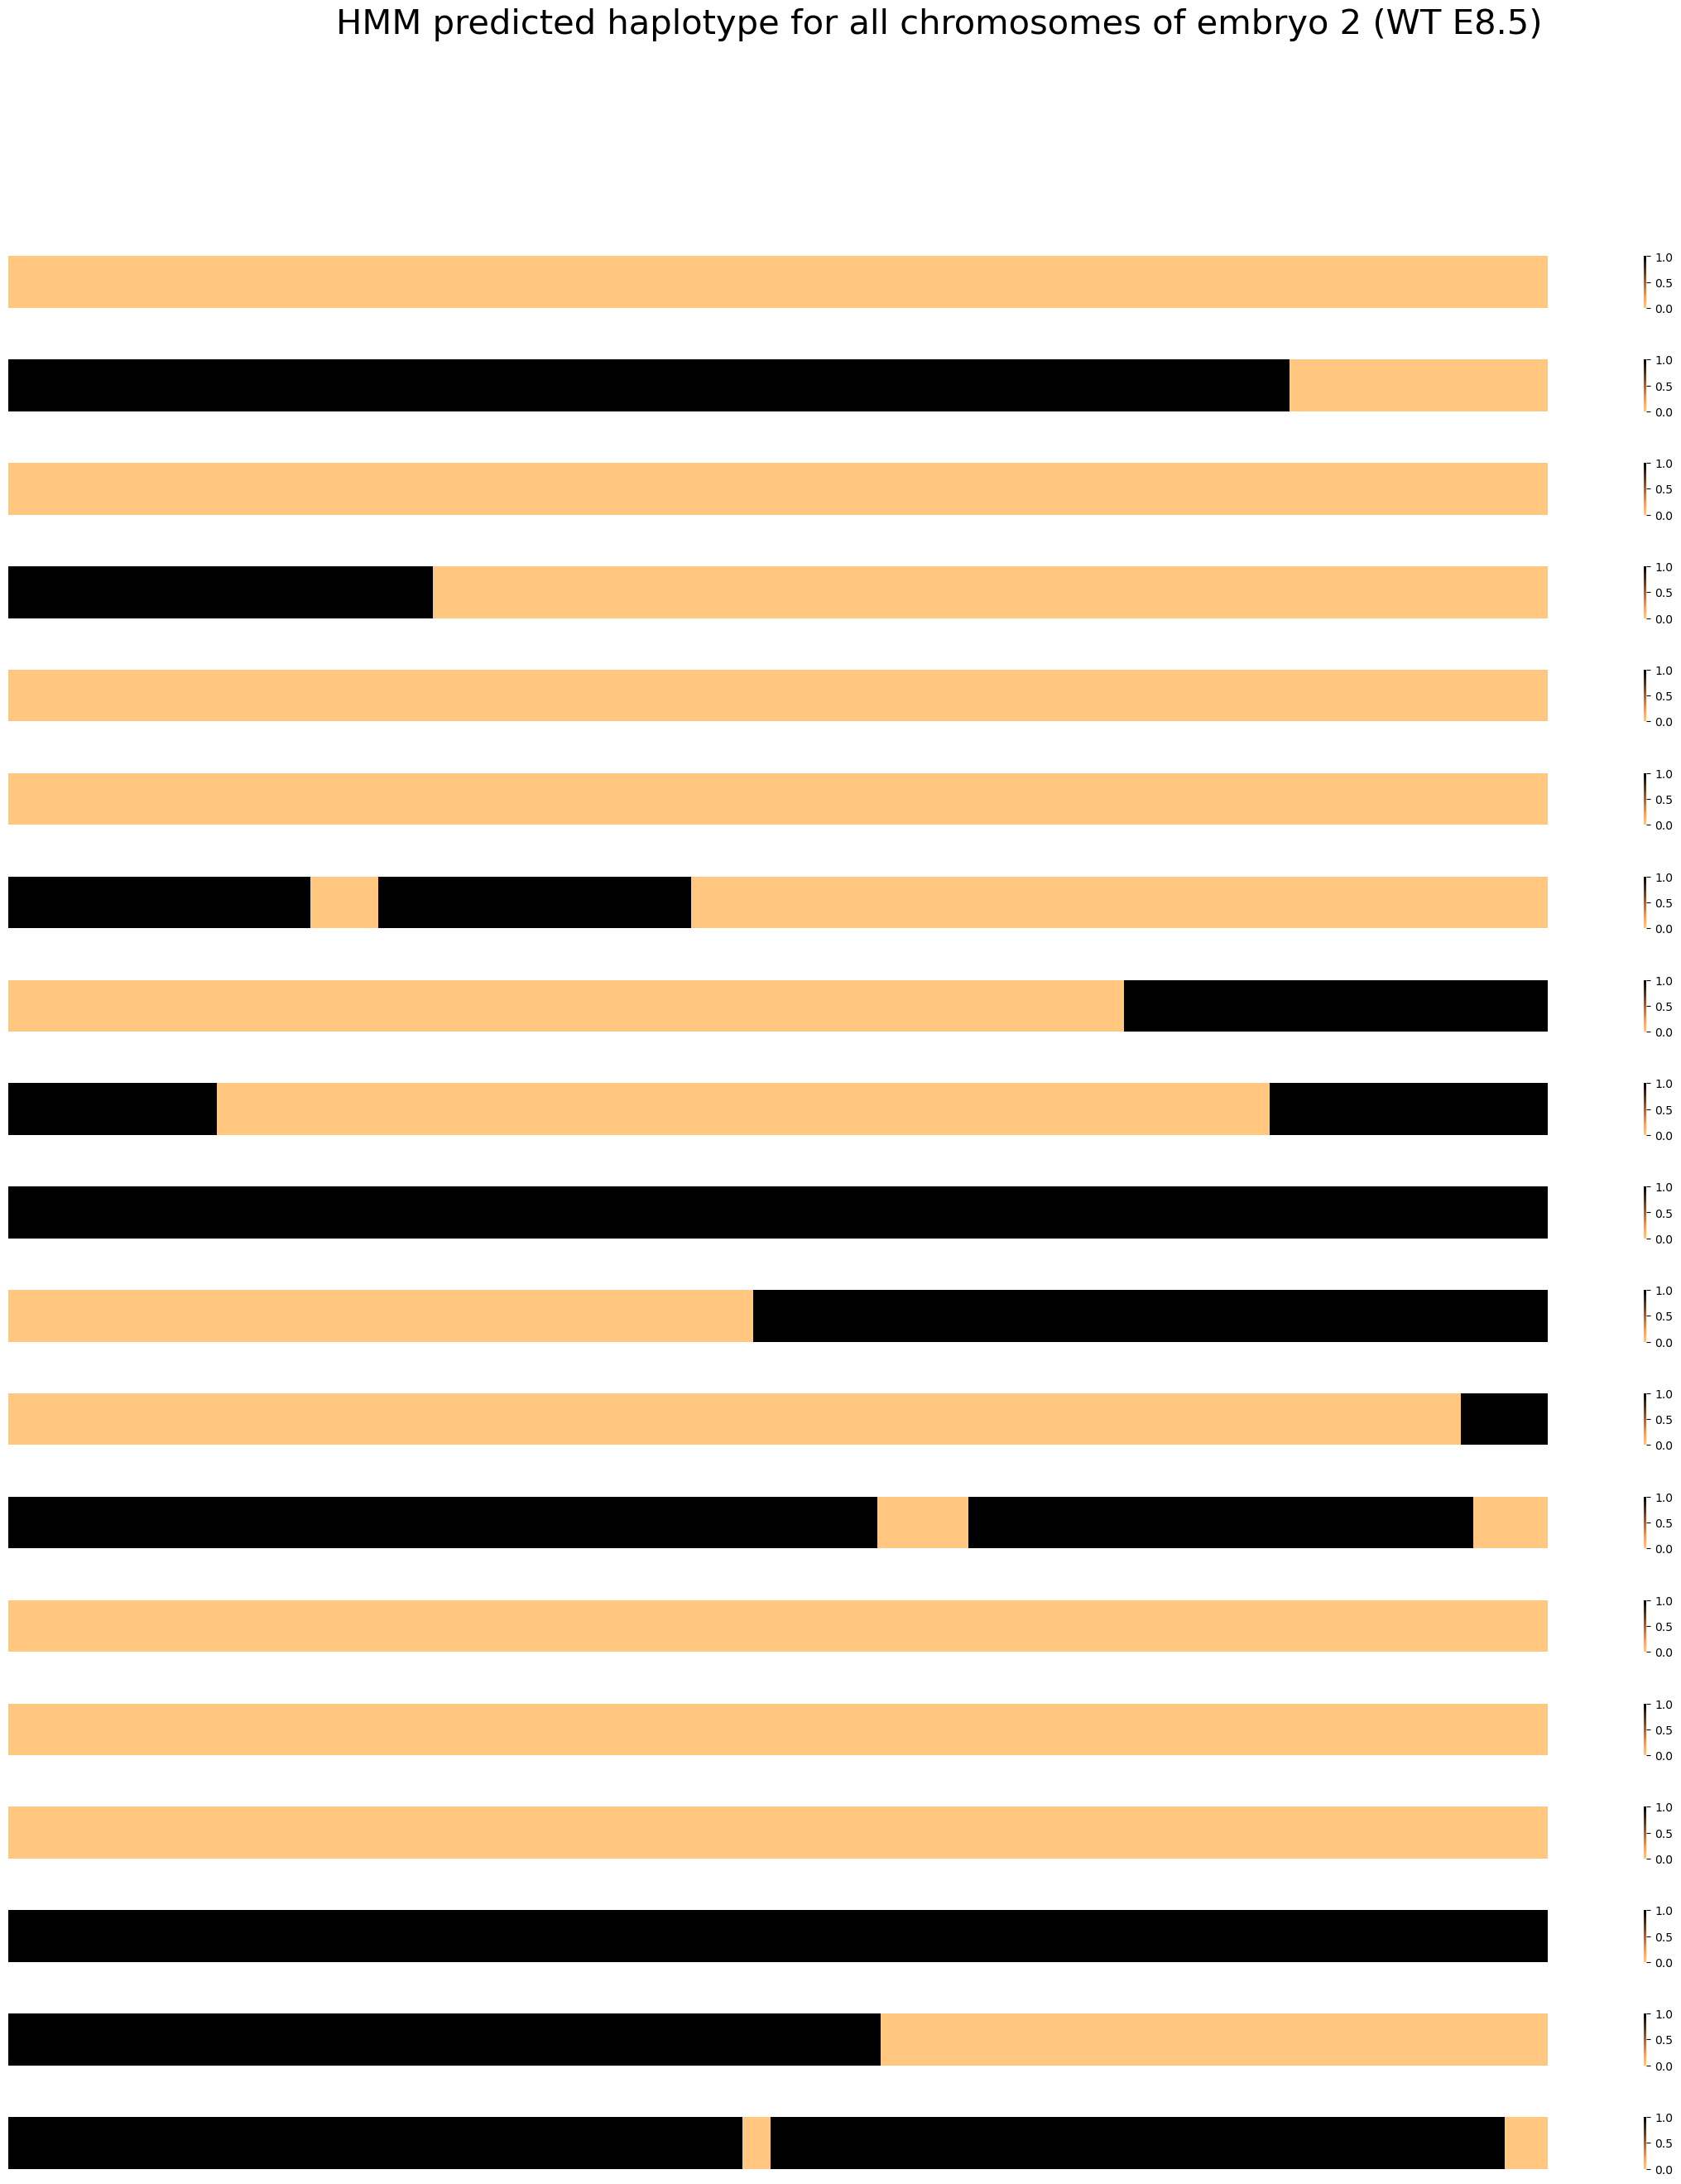

In [ ]:
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(19, hspace=1)
ax = gs.subplots()
fig.suptitle('HMM predicted haplotype for all chromosomes of embryo 2 (WT E8.5)', fontsize=30)
n = 0
df_list = list()
for chro in chromosomes:
    wt_df = pd.DataFrame(wt['embryo2'][chro].mean(axis=0), columns=['Ratio']).reset_index().rename(columns={"index":"Gene"})

    #convert ratio numbers into integers
    wt_df = ratio2int(wt_df)

    X = wt_df.obs_state_pro.to_numpy()
    X = X.reshape(-1, 1)
    X = X.astype(int)

    proba, state_sequence = model.decode(X)
    # print(state_sequence[1:10])
    # print(proba)

    df = pd.DataFrame(state_sequence)
    sns.heatmap(df.T, ax=ax[n], xticklabels=False, yticklabels=False, cmap="copper_r", vmin=0, vmax=1, linewidths=0, rasterized=True)

    df_comb = pd.concat([wt_df, df], axis=1, ignore_index=True)
    df_comb.columns = ['Gene', 'Ratio', 'Observed_State', 'Emitted_state']
    df_comb.insert(0, 'Chr', chro)
    df_list.append(df_comb)    

    n += 1

In [14]:
df_comb = pd.concat(df_list, axis=0, ignore_index=True)
df_comb.to_csv(f"/home/tornisie/HMM/test.csv", index=False, sep='\t')   

In [15]:
df_comb

,Chr,Gene,Ratio,Observed_State,Emitted_state
0,chr1,Mrpl15,0.031532,0.0,0
1,chr1,Lypla1,1.000000,5.0,0
2,chr1,Atp6v1h,0.567568,1.0,0
3,chr1,Rb1cc1,0.214286,0.0,0
4,chr1,Pcmtd1,0.625000,2.0,0
...,...,...,...,...,...
5002,chr19,Fam204a,0.472222,0.0,0
5003,chr19,Cacul1,0.750000,3.0,0
5004,chr19,Eif3a,0.581515,1.0,0
5005,chr19,Fam45a,1.000000,5.0,0


In [ ]:
with open("../metadata/gencode.vM10.annotation.simple.csv") as gtf:
    reader = csv.reader(gtf, delimiter=',')
    filtered_rows = []
    for row in reader:
        if row[5] in df_comb['Gene'].values:
            filtered_rows.append(row)

ref_df = pd.DataFrame(filtered_rows)
ref_df.columns =['Chr', 'Type', 'Start', 'End', 'Gene_type', 'Gene']

In [17]:
seg_df = pd.merge(df_comb[['Chr', 'Gene', 'Emitted_state']], ref_df[['Chr', 'Start', 'End', 'Gene']], on=['Chr', 'Gene'], how='inner')

In [18]:
seg_df

,Chr,Gene,Emitted_state,Start,End
0,chr1,Mrpl15,0,4773206,4785739
1,chr1,Lypla1,0,4807788,4848410
2,chr1,Atp6v1h,0,5070018,5162529
3,chr1,Rb1cc1,0,6206197,6276648
4,chr1,Pcmtd1,0,7088920,7173628
...,...,...,...,...,...
5007,chr19,Fam204a,0,60198586,60226697
5008,chr19,Cacul1,0,60524696,60581023
5009,chr19,Eif3a,0,60761116,60790693
5010,chr19,Fam45a,0,60811585,60836227


In [19]:
# Mark where a change in state occurs
seg_df['Block'] = (seg_df['Emitted_state'] != seg_df['Emitted_state'].shift()) | (seg_df['Chr'] != seg_df['Chr'].shift())

# Use cumsum to create a unique block ID for each contiguous block
seg_df['Block_id'] = seg_df['Block'].cumsum()

final_df = seg_df.groupby(['Chr', 'Emitted_state', 'Block_id']).agg({
    'Start': 'first',
    'End': 'last'
}).reset_index()

# Drop the 'block_id' since it's no longer needed
final_df = final_df.drop(columns=['Block_id'])

sorted_indexes = natsorted(final_df.index, key=lambda i: final_df.loc[i, 'Chr'])
final_df = final_df.loc[sorted_indexes].reset_index(drop=True)

print(final_df[['Chr', 'Start', 'End', 'Emitted_state']])

      Chr      Start        End  Emitted_state
0    chr1    4773206  195131586              0
1    chr2  160645888  181870830              0
2    chr2    3284212  158786637              1
3    chr3    5560188  159938664              0
4    chr4   82881751   99987294              0
5    chr4    3574875   70410443              1
6    chr5   64092950  151651242              0
7    chr6    4076899  149101680              0
8    chr7   29768552   30567960              0
9    chr7   67952827  144939925              0
10   chr7    3154658   29518641              1
11   chr7   30957770   67645268              1
12   chr8    3393006  107588482              0
13   chr8  109548017  128733200              1
14   chr9   42254177  110240178              0
15   chr9    3335478   37657312              1
16   chr9  110305173  123717625              1
17  chr10    3973118  128912816              1
18  chr11    3187360   78080383              0
19  chr11   78094660  121354445              1
20  chr12    

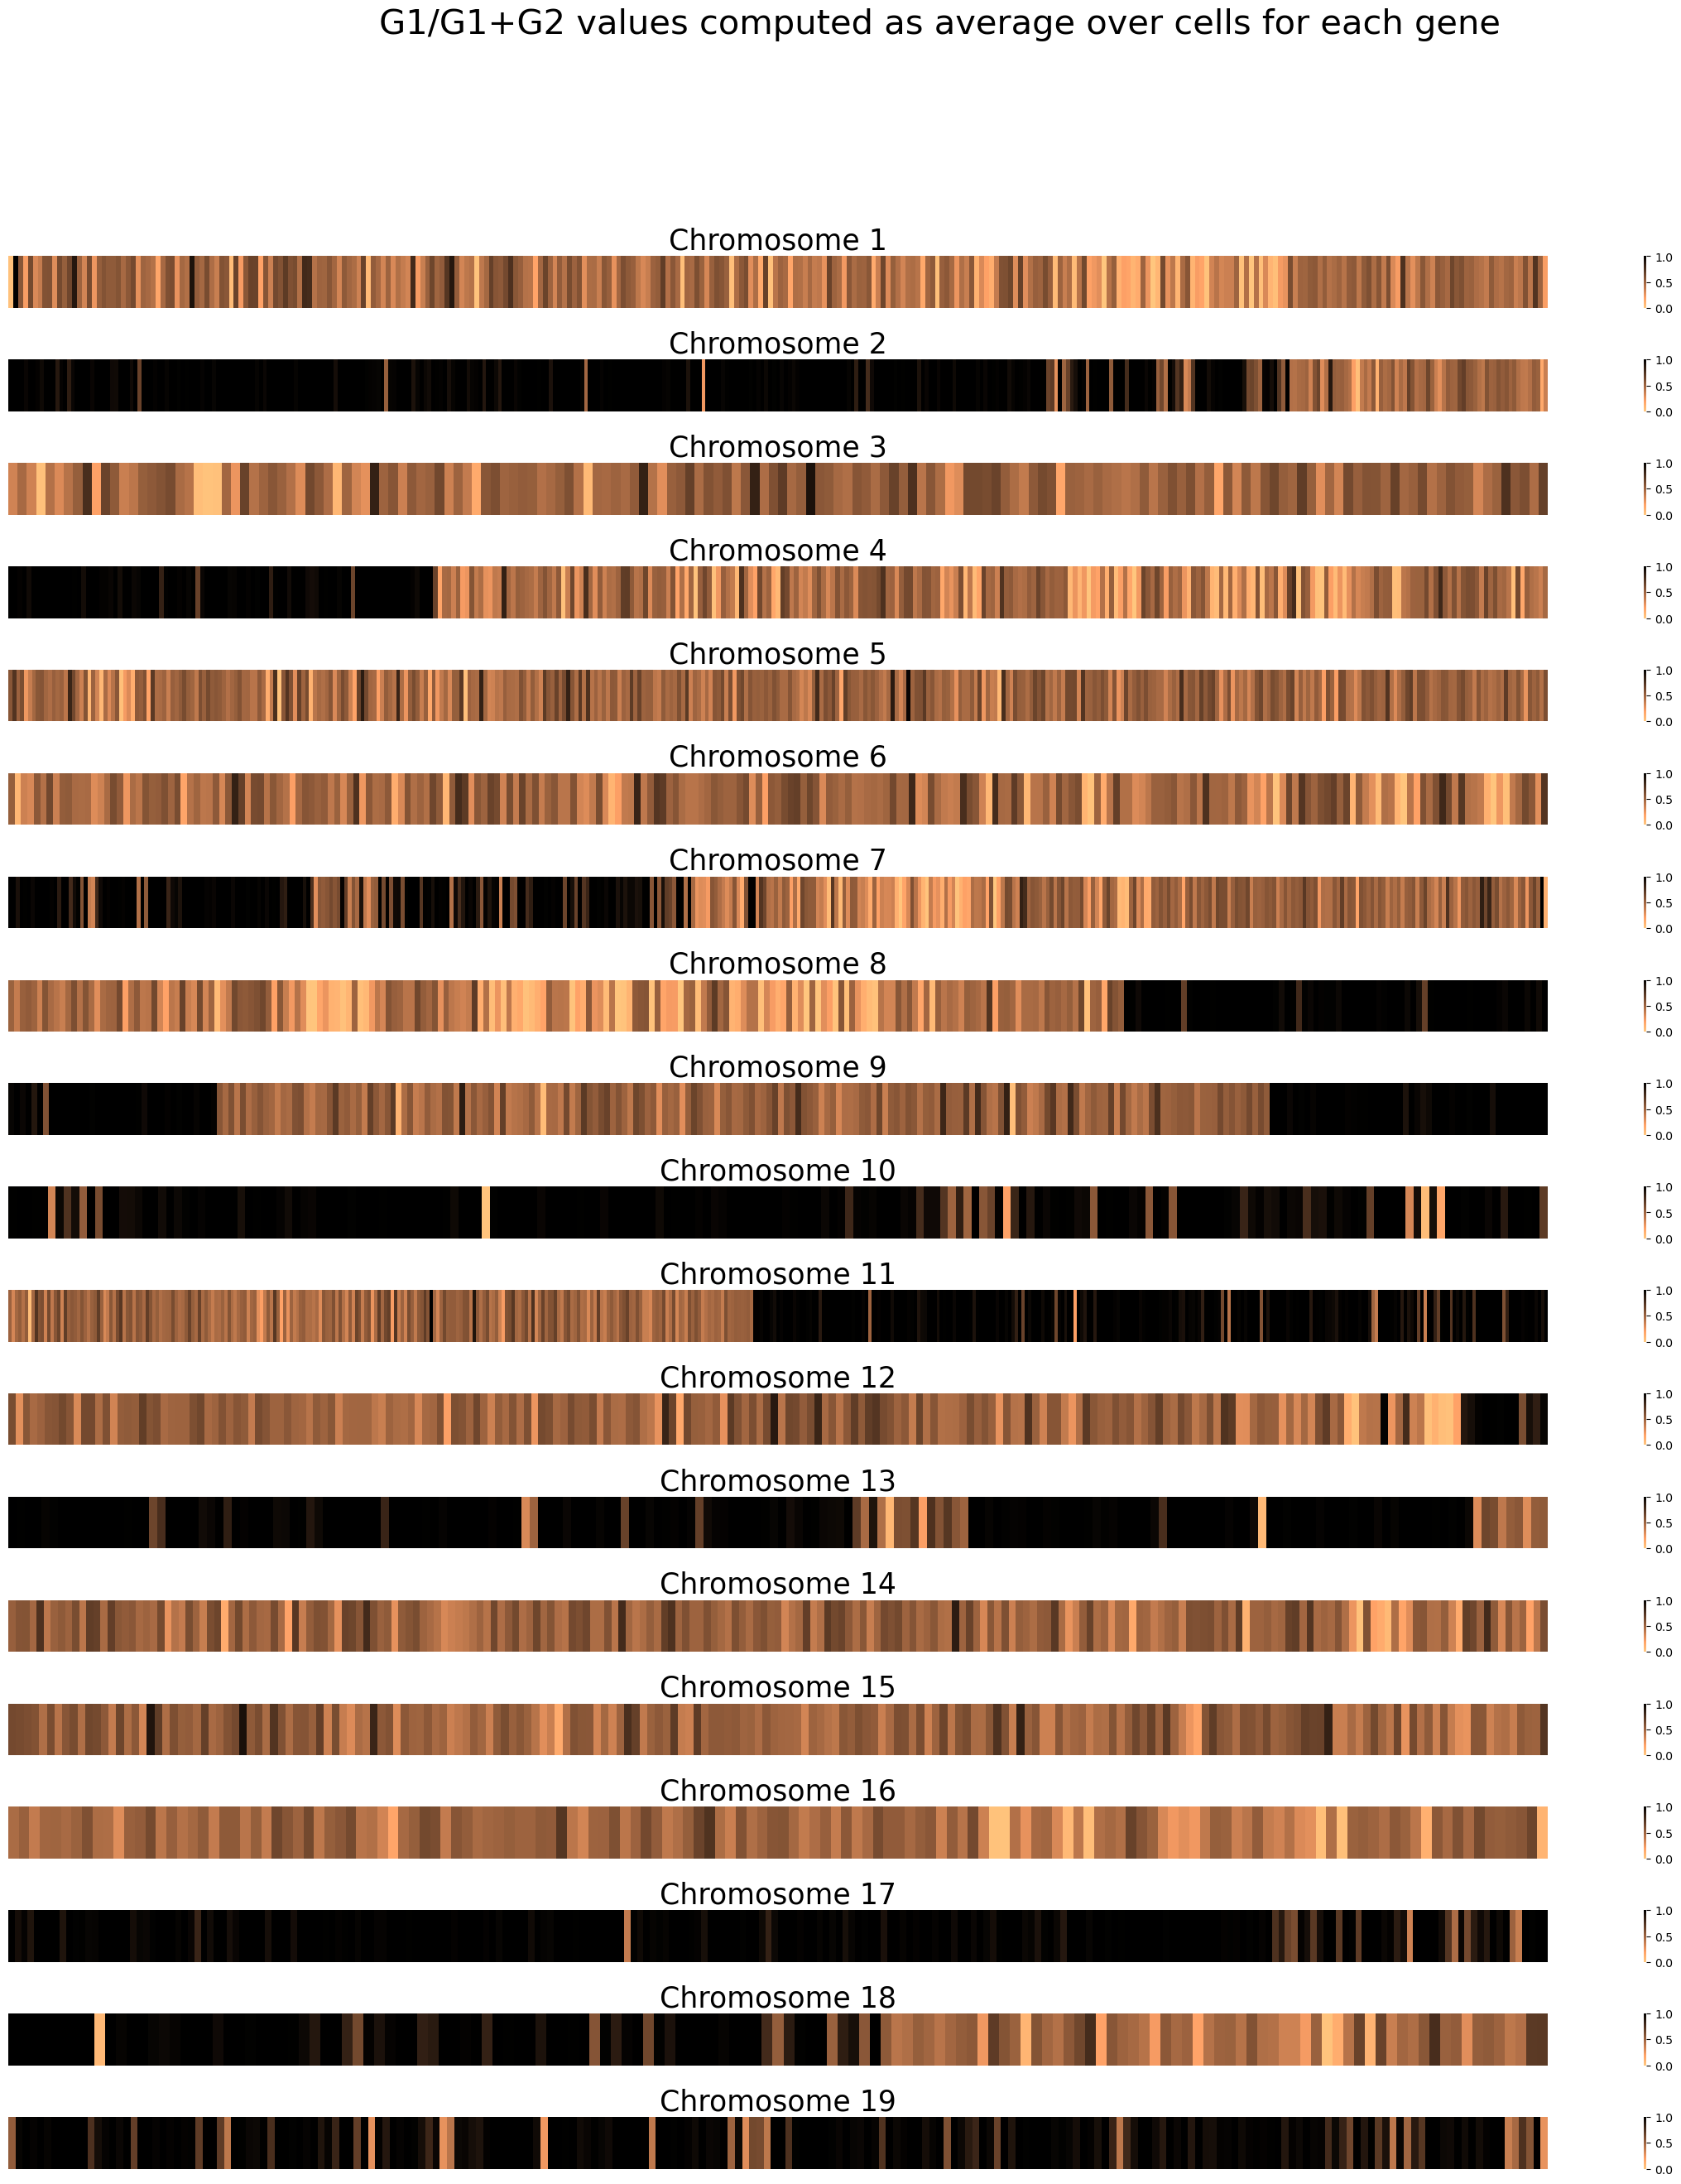

In [ ]:
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(19, hspace=1)
ax = gs.subplots()
fig.suptitle('G1/G1+G2 values computed as average over cells for each gene', fontsize=30)
n = 0
for chro in chromosomes:
    df = pd.DataFrame(wt['embryo2'][chro].mean(axis=0), columns=['Ratio'])
    df = df.T
    sns.heatmap(df, ax=ax[n], xticklabels=False, yticklabels=False, cmap="copper_r", vmin=0, vmax=1, linewidths=0, rasterized=True)
    ax[n].set_title(f"Chromosome {chro[3:]}", fontsize = 25)
    n += 1

In [ ]:
wt['embryo6']["chr1"].mean(axis=0)

Mrpl15     0.681034
Lypla1     0.866667
Atp6v1h    0.973333
Rb1cc1     0.923077
Pcmtd1     0.944444
             ...   
Dtl        0.632576
Ints7      0.506061
Lpgat1     0.450617
Syt14      0.400000
Cr1l       0.166667
Length: 323, dtype: float64

### Posterior predictive checks:
model validation technique for HMMs where you simulate data from your fitted model and compare it to the observed data to identify potential model inadequacies.

In [ ]:
# make real data examples
real_data = []
lengths = []

for embryo in list(wt.keys()):
    print(f"Processing {embryo}")
    for chr in chromosomes:
        df = pd.DataFrame(
            wt[embryo][chr].mean(axis=0), 
            columns=['Ratio']).reset_index().rename(columns={"index":"Gene"})

        # convert ratio numbers into integers
        df = ratio2int(df)
        
        X_sample = df.obs_state_pro.to_numpy()
        lengths.append(X_sample.shape[0])
        
        X_sample = X_sample.reshape(-1, 1)
        X_sample = X_sample.astype(int)

        real_data.append(X_sample.flatten())

Processing embryo7
Processing embryo13
Processing embryo9
Processing embryo18
Processing embryo1
Processing embryo3
Processing embryo6
Processing embryo16
Processing embryo10
Processing embryo14
Processing embryo17
Processing embryo2
Processing embryo15
Processing embryo4
Processing embryo12
Processing embryo8
Processing embryo5
Processing embryo11


In [36]:
real_data

[array([1, 0, 1, 0, 1, 3, 1, 0, 1, 1, 0, 0, 1, 5, 2, 0, 1, 0, 0, 1, 2, 1,
        1, 1, 1, 2, 2, 0, 0, 0, 1, 0, 0, 1, 3, 1, 1, 2, 0, 4, 1, 0, 1, 0,
        0, 1, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1, 3, 0, 2, 1, 1, 0, 2, 3, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 3, 3, 2, 0, 0, 0,
        2, 2, 0, 2, 1, 1, 0, 1, 1, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [ ]:
lengths

In [37]:
sim_data = list()
for i in range(len(lengths)):
    sim_data.append(model.sample(lengths[i])[0].flatten())
    

In [38]:
sim_data

[array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 5, 0, 0, 1, 3, 0, 1, 1, 0,
        0, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 2, 1, 2, 0, 0, 3, 0, 2, 0, 2, 1,
        1, 0, 3, 1, 1, 4, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2,
        1, 1, 1, 0, 3, 2, 0, 0, 1, 1, 2, 0, 1, 4, 2, 2, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 3, 1, 1, 4, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 4, 0, 1, 0,
        0, 1, 1, 0, 0, 2, 1, 0, 2, 0, 1, 0, 0, 1, 3, 1, 2, 1, 0, 0, 1, 3,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 1, 0, 2, 1, 0, 0, 1, 0,
        0, 0, 1, 3, 1, 1, 2, 0, 0, 2, 1, 1, 2, 1, 2, 3, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 2, 2, 0, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 4, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 1, 1, 2, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 3, 1, 1, 0, 0, 0, 1, 2, 0,
        1, 0, 3, 0, 0, 1, 0, 2, 1, 0, 

Statistical comparisons between real and simulated data

In [ ]:
# Basic comparison
real_all = np.concatenate(real_data)
sim_all = np.concatenate(sim_data)

results = {}

# 1. Basic distributional properties
results['mean_real'] = np.mean(real_all)
results['mean_sim'] = np.mean(sim_all)
results['std_real'] = np.std(real_all)
results['std_sim'] = np.std(sim_all)

real_unique, real_counts = np.unique(real_all, return_counts=True)
sim_unique, sim_counts = np.unique(sim_all, return_counts=True)
    
results['n_states_real'] = len(real_unique)
results['n_states_sim'] = len(sim_unique)

# 4. Transition rate analysis
def calculate_transition_rate(sequence):
    if len(sequence) <= 1:
        return 0
    return np.sum(np.diff(sequence) != 0) / (len(sequence) - 1)

real_transitions = [calculate_transition_rate(seq) for seq in real_data]
sim_transitions = [calculate_transition_rate(seq) for seq in sim_data]

results['transition_rate_real'] = np.mean(real_transitions)
results['transition_rate_sim'] = np.mean(sim_transitions)

# Run basic comparisons

for key, value in results.items():
    print(f"{key}: {value:.4f}")

mean_real: 2.7655
mean_sim: 2.6221
std_real: 2.1856
std_sim: 2.1826
n_states_real: 6.0000
n_states_sim: 6.0000
transition_rate_real: 0.3962
transition_rate_sim: 0.4365


In [41]:
# Formal comparison
from scipy import stats    
# Flatten data
real_all = np.concatenate(real_data)
sim_all = np.concatenate(sim_data)

tests = {}

# 1. Kolmogorov-Smirnov test for distribution similarity
ks_stat, ks_p = stats.ks_2samp(real_all, sim_all)
tests['ks_test'] = {'statistic': ks_stat, 'p_value': ks_p}

# 2. Mann-Whitney U test for median differences
mw_stat, mw_p = stats.mannwhitneyu(real_all, sim_all, alternative='two-sided')
tests['mann_whitney'] = {'statistic': mw_stat, 'p_value': mw_p}

# 3. Chi-square test for state proportions
real_unique, real_counts = np.unique(real_all, return_counts=True)
sim_unique, sim_counts = np.unique(sim_all, return_counts=True)

# Align states (in case some states are missing in one dataset)
all_states = sorted(set(real_unique) | set(sim_unique))
real_props = np.array([real_counts[np.where(real_unique == state)[0][0]] 
                        if state in real_unique else 0 for state in all_states])
sim_props = np.array([sim_counts[np.where(sim_unique == state)[0][0]] 
                        if state in sim_unique else 0 for state in all_states])

# Normalize to proportions
real_props = real_props / np.sum(real_props)
sim_props = sim_props / np.sum(sim_props)

chi2_stat, chi2_p = stats.chisquare(sim_props, real_props)
tests['chi_square'] = {'statistic': chi2_stat, 'p_value': chi2_p}
    
# 4. Test transition rates
def calculate_transition_rate(sequence):
    if len(sequence) <= 1:
        return 0
    return np.sum(np.diff(sequence) != 0) / (len(sequence) - 1)
    
real_transitions = [calculate_transition_rate(seq) for seq in real_data]
sim_transitions = [calculate_transition_rate(seq) for seq in sim_data]

trans_ks_stat, trans_ks_p = stats.ks_2samp(real_transitions, sim_transitions)
tests['transition_ks_test'] = {'statistic': trans_ks_stat, 'p_value': trans_ks_p}
    

# Run statistical tests
print("Statistical Test Results:")
print("=" * 50)
for test_name, result in tests.items():
    print(f"{test_name}:")
    print(f"  Statistic: {result['statistic']:.6f}")
    print(f"  P-value: {result['p_value']:.6f}")
    print(f"  Significant: {'Yes' if result['p_value'] < 0.05 else 'No'}")
    print()


Statistical Test Results:
ks_test:
  Statistic: 0.032815
  P-value: 0.000000
  Significant: Yes

mann_whitney:
  Statistic: 4247516464.000000
  P-value: 0.000000
  Significant: Yes

chi_square:
  Statistic: 0.004587
  P-value: 1.000000
  Significant: No

transition_ks_test:
  Statistic: 0.134503
  P-value: 0.004072
  Significant: Yes



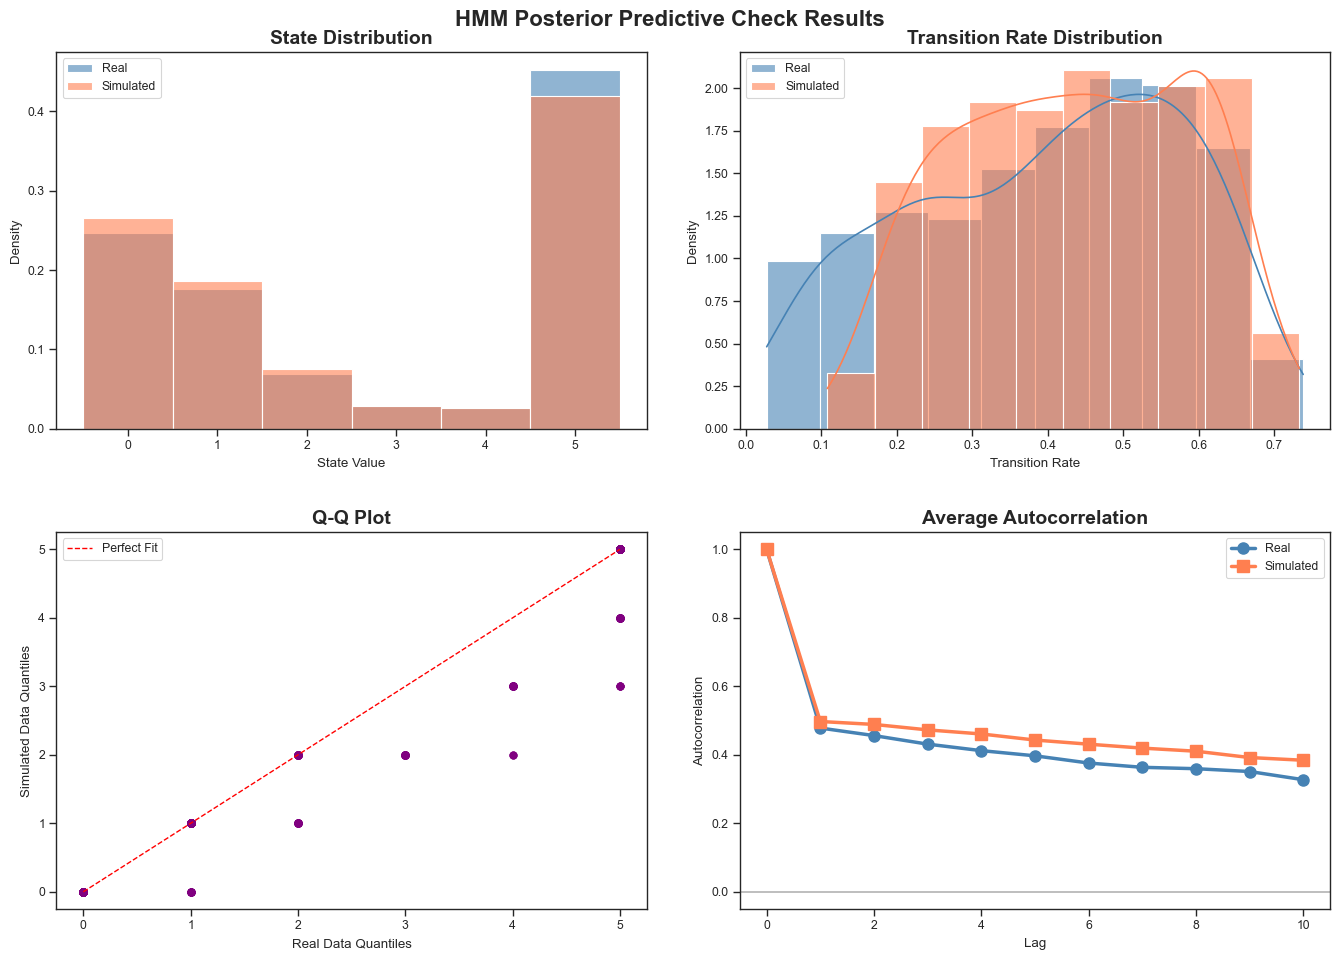

In [60]:
def create_seaborn_hmm_comparison_plots(real_sequences, simulated_sequences):
    """Create HMM comparison plots using seaborn styling"""
    
    # Set seaborn style
    sns.set_style("ticks")
    sns.set_palette("rocket")
    sns.set_context("paper")
    
    # Calculate required data
    real_all = np.concatenate(real_sequences)
    sim_all = np.concatenate(simulated_sequences)
    
    # Transition rates
    def calculate_transition_rate(sequence):
        if len(sequence) <= 1:
            return 0
        return np.sum(np.diff(sequence) != 0) / (len(sequence) - 1)
    
    real_transitions = [calculate_transition_rate(seq) for seq in real_sequences]
    sim_transitions = [calculate_transition_rate(seq) for seq in simulated_sequences]
    
    # Autocorrelation calculation
    def autocorr(x, max_lag=10):
        n = len(x)
        x = x - np.mean(x)
        autocorrs = []
        for lag in range(max_lag + 1):
            if lag == 0:
                autocorrs.append(1.0)
            else:
                c = np.mean(x[:-lag] * x[lag:]) / np.var(x) if lag < n else 0
                autocorrs.append(c)
        return autocorrs
    
    # Average autocorrelation
    max_lag = 10
    real_autocorr_avg = np.zeros(max_lag + 1)
    sim_autocorr_avg = np.zeros(max_lag + 1)
    
    real_count = 0
    for seq in real_sequences[:min(200, len(real_sequences))]:
        if len(seq) > max_lag + 5:
            seq_flat = seq.flatten() if hasattr(seq, 'flatten') else seq
            real_autocorr_avg += np.array(autocorr(seq_flat, max_lag))
            real_count += 1
    
    sim_count = 0
    for seq in simulated_sequences[:min(200, len(simulated_sequences))]:
        if len(seq) > max_lag + 5:
            sim_autocorr_avg += np.array(autocorr(seq, max_lag))
            sim_count += 1
    
    if real_count > 0:
        real_autocorr_avg /= real_count
    if sim_count > 0:
        sim_autocorr_avg /= sim_count
    
    # Create 2x2 subplot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. State Distribution
    unique_states = sorted(set(real_all) | set(sim_all))
    bins = np.arange(min(unique_states) - 0.5, max(unique_states) + 1.5, 1)
    
    sns.histplot(real_all, bins=bins, color='steelblue', alpha=0.6, 
                label='Real', stat='density', kde=False, ax=axes[0, 0])
    sns.histplot(sim_all, bins=bins, color='coral', alpha=0.6, 
                label='Simulated', stat='density', kde=False, ax=axes[0, 0])
    axes[0, 0].set_title('State Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('State Value')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    
    # 2. Transition Rate Distribution
    sns.histplot(real_transitions, color='steelblue', alpha=0.6, 
                label='Real', stat='density', kde=True, ax=axes[0, 1])
    sns.histplot(sim_transitions, color='coral', alpha=0.6, 
                label='Simulated', stat='density', kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Transition Rate Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Transition Rate')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()
    
    # 3. Q-Q Plot
    real_sorted = np.sort(real_all)
    sim_sorted = np.sort(sim_all)
    n_points = min(len(real_sorted), len(sim_sorted), 1000)
    real_quantiles = np.quantile(real_sorted, np.linspace(0, 1, n_points))
    sim_quantiles = np.quantile(sim_sorted, np.linspace(0, 1, n_points))
    
    axes[1, 0].scatter(real_quantiles, sim_quantiles, alpha=0.7, s=25, color='purple')
    min_val = min(np.min(real_quantiles), np.min(sim_quantiles))
    max_val = max(np.max(real_quantiles), np.max(sim_quantiles))
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=1, label='Perfect Fit')
    axes[1, 0].set_title('Q-Q Plot', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Real Data Quantiles')
    axes[1, 0].set_ylabel('Simulated Data Quantiles')
    axes[1, 0].legend()
    
    # 4. Average Autocorrelation
    lags = np.arange(0, max_lag + 1)
    axes[1, 1].plot(lags, real_autocorr_avg, marker='o', linewidth=2.5, 
                   markersize=8, color='steelblue', label='Real')
    axes[1, 1].plot(lags, sim_autocorr_avg, marker='s', linewidth=2.5, 
                   markersize=8, color='coral', label='Simulated')
    axes[1, 1].set_xlabel('Lag')
    axes[1, 1].set_ylabel('Autocorrelation')
    axes[1, 1].set_title('Average Autocorrelation', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Improve overall appearance
    plt.tight_layout(pad=3.0)
    
    # Add overall title
    fig.suptitle('HMM Posterior Predictive Check Results', 
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.savefig("figures/post_pred_check.pdf", bbox_inches='tight')

# Usage with your data:
create_seaborn_hmm_comparison_plots(real_data, sim_data)


### Testing parameters distribution over training size - all the probabilities and the log-likelihood of the predicted sequences
For stage E8.5: we have 10 embryos (19 chromosomes each) so 190 max training sequences (consider using other stages to increase this number)
Results: 
- there might be a bias towards one of the hidden states for the emission probabilities, based on the dataset (time point)
- it's important to preset start and transition probabilities, but the model can learn well the emissions on its own during the fitting
- both transition and emission probabilities stay consistent no matter the number of sequences used for fitting, but the start ones can change (as expected)
- the log-likelihood of the decoded sequences does not vary much based on the amount of sequences used for fitting

In [ ]:
np.random.seed(75)  # Set a random seed

fit_embryos = list(wt.keys())[1:]

# fit the model on 10 to 190 sequences and store the probabilities 
# and the log-likelihood of the predicted sequences

startprob_d = dict()
transmat_d = dict()
emissionprob_d = dict()
proba_d = dict()

for i in range(1, 20):
    fit_chromosomes = sample(chromosomes, i)

    X = list()
    lengths = list()
    for embryo in fit_embryos:
        print(f"Processing {embryo}")
        for chr in fit_chromosomes:
            fit_df = pd.DataFrame(
                wt[embryo][chr].mean(axis=0), 
                columns=['Ratio']).reset_index().rename(columns={"index":"Gene"})

            # convert ratio numbers into integers
            fit_df = ratio2int(fit_df)
            
            X_train = fit_df.obs_state_pro.to_numpy()
            lengths.append(X_train.shape[0])
            # if int(5) not in X_train:
            #     X_train = np.concatenate((X_train + np.array([[5]])))

            X_train = X_train.reshape(-1, 1)
            X_train = X_train.astype(int)

            X.append(X_train)

    X = np.concatenate(X)

    model = CategoricalHMM(n_components=2, params='ste', init_params='', random_state=23, n_iter=10000)
    model.startprob_ = np.array([0.5, 0.5])

    model.transmat_ = np.array([[0.998, 0.002],
                                [0.002, 0.998]])

    model.emissionprob_ = np.array([[0.30, 0.15, 0.15, 0.30, 0.05, 0.05],
                                    [0.001, 0.05, 0.05, 0.299, 0.30, 0.30]])

    model.fit(X, lengths)

    # save the model parameters
    startprob_d[i] = model.startprob_
    transmat_d[i] = model.transmat_
    emissionprob_d[i] = model.emissionprob_

    # Decode
    print(f"Decoding for {i} chromosomes")
    decode_embryo = list(wt.keys())[1]
    
    probabilities = list()
    n = 0
    for chro in chromosomes:
        decode_df = pd.DataFrame(wt[decode_embryo][chro].mean(axis=0), columns=['Ratio']).reset_index().rename(columns={"index":"Gene"})

        decode_df = ratio2int(decode_df)

        X_decode = decode_df.obs_state_pro.to_numpy()
        X_decode = X_decode.reshape(-1, 1)
        X_decode = X_decode.astype(int)

        proba, state_sequence = model.decode(X_decode)
        probabilities.append(proba)
        n += 1

    proba_d[i] = probabilities

Processing embryo13
Processing embryo9
Processing embryo18
Processing embryo1
Processing embryo3
Processing embryo6
Processing embryo16
Processing embryo10
Processing embryo14
Processing embryo17
Processing embryo2
Processing embryo15
Processing embryo4
Processing embryo12
Processing embryo8
Processing embryo5
Processing embryo11
Decoding for 1 chromosomes
Processing embryo13
Processing embryo9
Processing embryo18
Processing embryo1
Processing embryo3
Processing embryo6
Processing embryo16
Processing embryo10
Processing embryo14
Processing embryo17
Processing embryo2
Processing embryo15
Processing embryo4
Processing embryo12
Processing embryo8
Processing embryo5
Processing embryo11
Decoding for 2 chromosomes
Processing embryo13
Processing embryo9
Processing embryo18
Processing embryo1
Processing embryo3
Processing embryo6
Processing embryo16
Processing embryo10
Processing embryo14
Processing embryo17
Processing embryo2
Processing embryo15
Processing embryo4
Processing embryo12
Processi

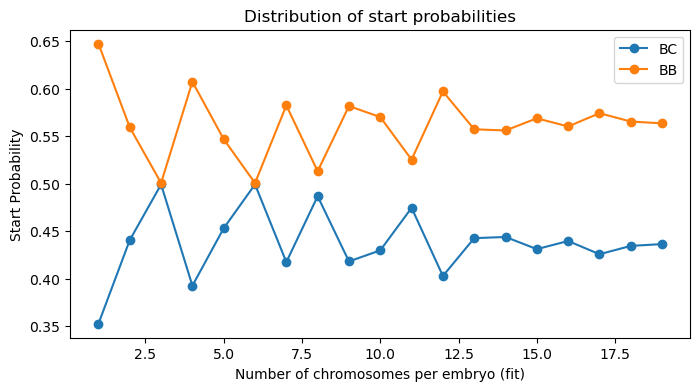

In [23]:
# Prepare lists for plotting
keys = list(startprob_d.keys())
value_1 = [startprob_d[key][0] for key in keys]
value_2 = [startprob_d[key][1] for key in keys]

# Create a plot
plt.figure(figsize=(8, 4))
plt.plot(keys, value_1, label='BC', marker='o')
plt.plot(keys, value_2, label='BB', marker='o')

# Adding titles and labels
plt.title('Distribution of start probabilities')
plt.xlabel('Number of chromosomes per embryo (fit)')
plt.ylabel('Start Probability')
plt.legend()

# Show the plot
plt.savefig("figures/startprob_dist_fitsize.pdf", bbox_inches='tight')

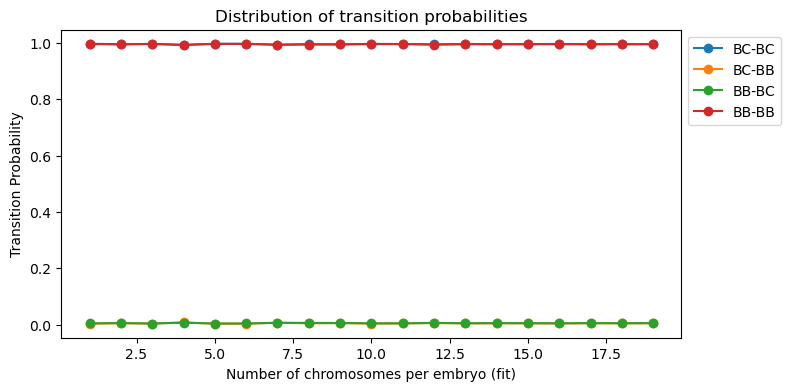

In [24]:
# Prepare lists for plotting
keys = list(transmat_d.keys())
value_1 = [transmat_d[key][0][0] for key in keys]
value_2 = [transmat_d[key][0][1] for key in keys]
value_3 = [transmat_d[key][1][0] for key in keys]
value_4 = [transmat_d[key][1][1] for key in keys]

# Create a plot
plt.figure(figsize=(8, 4))
plt.plot(keys, value_1, label='BC-BC', marker='o')
plt.plot(keys, value_2, label='BC-BB', marker='o')
plt.plot(keys, value_3, label='BB-BC', marker='o')
plt.plot(keys, value_4, label='BB-BB', marker='o')

# Adding titles and labels
plt.title('Distribution of transition probabilities')
plt.xlabel('Number of chromosomes per embryo (fit)')
plt.ylabel('Transition Probability')
plt.legend(bbox_to_anchor=(1, 1))

plt.savefig("figures/transprob_dist_fitsize.pdf",bbox_inches='tight')

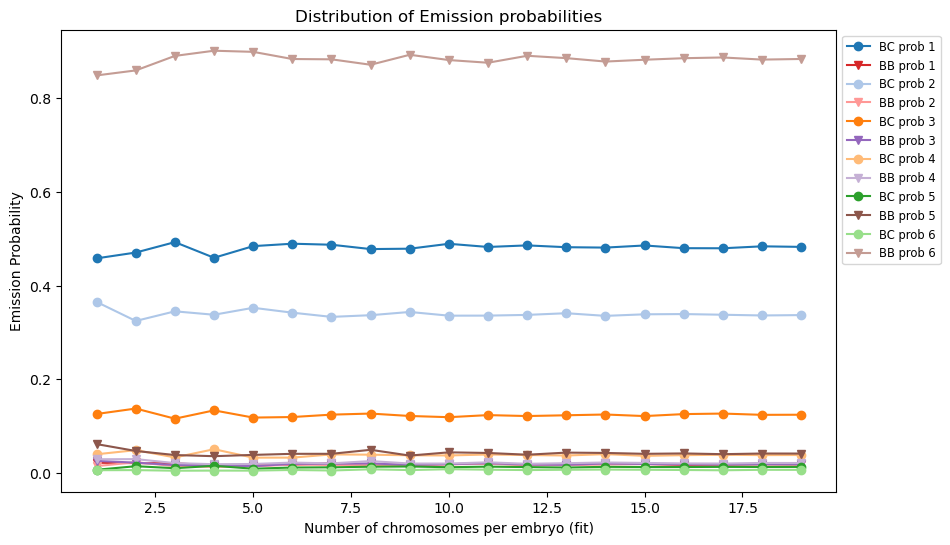

In [25]:
keys = list(emissionprob_d.keys())
line_1_values = [emissionprob_d[key][0] for key in keys]
line_2_values = [emissionprob_d[key][1] for key in keys]

# Create a plot for each set of line values
tab20 = plt.get_cmap('tab20')
plt.figure(figsize=(10, 6))

for i in range(6):
    # Plot the distribution of each of the six values in each line
    plt.plot(keys, [line[i] for line in line_1_values], label=f'BC prob {i+1}', marker='o', color=tab20(i))
    plt.plot(keys, [line[i] for line in line_2_values], label=f'BB prob {i+1}', marker='v', color=tab20(i + 6))

# Adding titles and labels
plt.title('Distribution of Emission probabilities')
plt.xlabel('Number of chromosomes per embryo (fit)')
plt.ylabel('Emission Probability')
plt.legend(ncol=1, fontsize='small', bbox_to_anchor=(1, 1))

plt.savefig("figures/emissionprob_dist_fitsize.pdf", bbox_inches='tight')


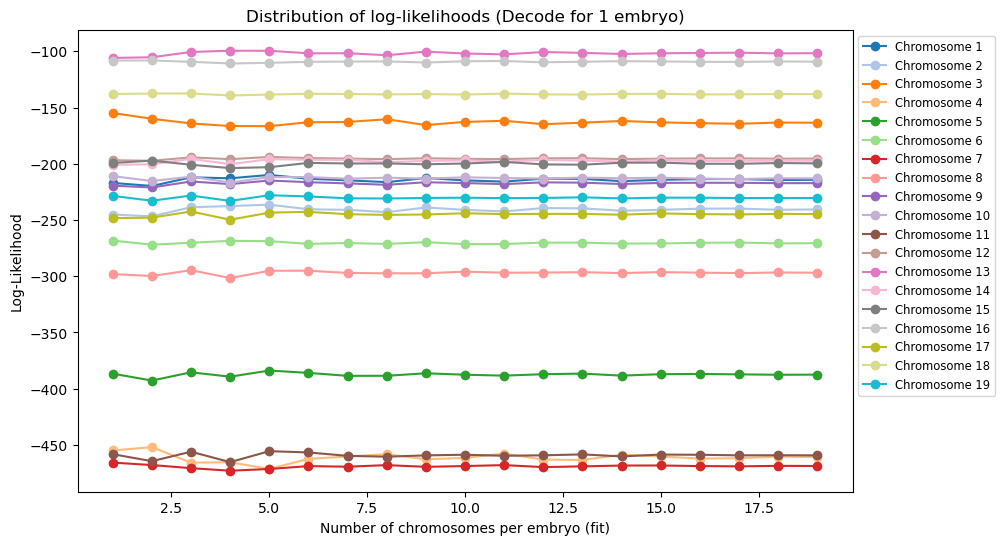

In [26]:
# Prepare lists for plotting
keys = list(proba_d.keys())
num_values = len(next(iter(proba_d.values())))  # all arrays have the same length

# Create a plot for each position in array lines
tab20 = plt.get_cmap('tab20')
plt.figure(figsize=(10, 6))

for i in range(num_values):
    values_at_index = [array[i] for array in proba_d.values()]
    plt.plot(keys, values_at_index, label=f'Chromosome {i+1}', marker='o', color=tab20(i))

# Adding titles and labels
plt.title('Distribution of log-likelihoods (Decode for 1 embryo)')
plt.xlabel('Number of chromosomes per embryo (fit)')
plt.ylabel('Log-Likelihood')
plt.legend(bbox_to_anchor=(1, 1), fontsize='small')

plt.savefig("figures/loglikelyhood_dist_fitsize.pdf", bbox_inches='tight')